## Exercise 1

Create a vectorized version of log and exp math function for 1D array A = [2, 5, 10, 3, 8]

Results should be: 
+ [0.6931472 1.609438  2.3025851 1.0986123 2.0794415]
+ [7.3890562e+00 1.4841316e+02 2.2026465e+04 2.0085537e+01 2.9809580e+03]

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
os.environ["NUMBA_ENABLE_CUDASIM"] = "1"
from numba import vectorize, int64, float32, jit, njit, vectorize, cuda

In [2]:
@vectorize([float32(float32)], target='parallel', fastmath=True)
def vec_log(x):
    tmp =  np.log(x)
    return tmp

@vectorize([float32(float32)], target='parallel', fastmath=True)
def vec_exp(x):
    tmp =  np.exp(x)
    return tmp

In [3]:
a = np.array([2,5,10,3,8]).astype(np.float32)

print(vec_log(a))
print(vec_exp(a))

[0.6931472 1.609438  2.3025851 1.0986123 2.0794415]
[7.3890562e+00 1.4841316e+02 2.2026465e+04 2.0085537e+01 2.9809580e+03]


## Exerice 2
Compute the value of a Gaussian probability density function at $x$ with $mean = 1$, $\sigma = 1$, lower and upper bound in $(-3, 3)$ and $size = 100000$

In [4]:
@vectorize([float32(float32)], target='parallel', fastmath=True)
def gauss(x):
    mean = 1
    sigma = 1
    return np.exp( - 0.5 * (x - mean)**2 / sigma**2 ) / np.sqrt(2*np.pi) / sigma

In [5]:
arr = np.linspace(-3, 3, 100000).astype(np.float32)
pdf = gauss(arr)

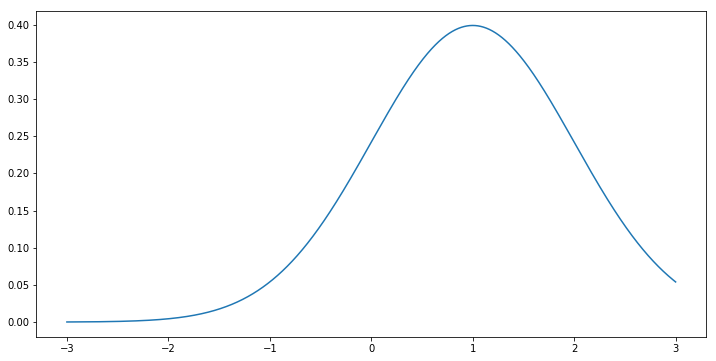

In [6]:
plt.figure(figsize=(12,6))
plt.plot(arr, pdf)
plt.show()

## Exercise 3

Create a "zero suppression" function. A common operation when working with waveforms is to force all samples values below a certain absolute magnitude to be zero, as a way to eliminate low amplitude noise. 
Plot the data before and after the application of the zero_suppress function.

$thresold = 15$

In [7]:
n = 100000
noise = np.random.normal(size=n) * 3
pulses = np.maximum(np.sin(np.arange(n) / (n / 23)) - 0.3, 0.0)
data = ((pulses * 300) + noise).astype(np.int16)

In [8]:
@vectorize([float32(float32)], target='parallel', fastmath=True)
def zero_suppress(x):
    threshold = 15
    tmp = 0
    if x > threshold:
        tmp = x
    return tmp

In [9]:
data_clean = zero_suppress(data)

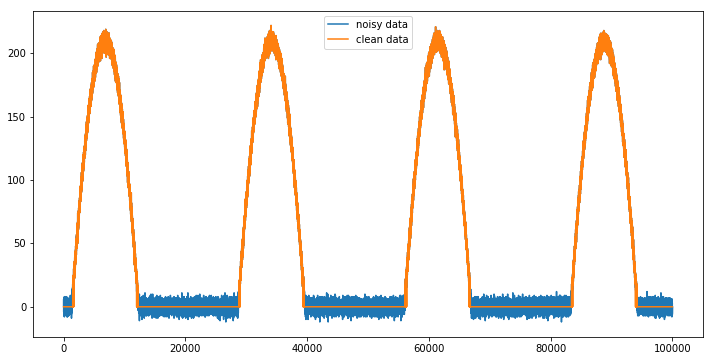

In [10]:
plt.figure(figsize=(12,6))
plt.plot(np.arange(n), data, label='noisy data')
plt.plot(np.arange(n), data_clean, label='clean data')
plt.legend()
plt.show()

## Exercise 4

Calculate the Sigmoid kernel between the matrix X and Y defined as below. The Sigmoid kernel is defined as:

$k(x,y) = \tanh(\alpha x^T y + c) $

In [11]:
X = np.random.rand(3)
Y = np.random.rand(3)

In [12]:
@cuda.jit
def sigmoid_kernel(x, y, res):
    alpha = 1
    c = 0

    pos = cuda.grid(1)
    
    if (pos < x.shape[0]) and (pos < y.shape[0]):
        res += x[pos]*y[pos]
        
    res = np.tanh(alpha*res + c)

In [13]:
threadsperblock = 3
blockspergrid = (X.shape[0] + (threadsperblock - 1)) // threadsperblock

res = 0

sigmoid_kernel[threadsperblock, blockspergrid](X,Y,res)

print(res)

0


## Exercise 5

Create a kernel function similar to the ```double_kernel``` see during the lecture and create a new function that takes a 3 dimensional matrix as input calculating the $cos$ for each element and then returns the result. The shape of the matrix must be $256X256X256$. The matrix can be randomly generated

In [14]:
@cuda.jit
def double_kernel_3D(io_array):
    dim, row, col = cuda.grid(3)
    if dim < io_array.shape[0] and row < io_array.shape[1] and col < io_array.shape[2]:
        io_array[dim][row][col] *= 2 # do the computation

In [15]:
import math

# Host code   
data = np.random.random((32,32,32))

# Configure the blocks
threadsperblock = (128, 32, 8)
blockspergrid_x = int(math.ceil(data.shape[0] / threadsperblock[0]))
blockspergrid_y = int(math.ceil(data.shape[1] / threadsperblock[1]))
blockspergrid_z = int(math.ceil(data.shape[2] / threadsperblock[2]))
blockspergrid = (blockspergrid_x, blockspergrid_y, blockspergrid_z)

double_kernel_3D[blockspergrid, threadsperblock](data)
print(data)

[[[1.32027083 0.14723292 1.53032013 ... 1.73306761 1.65330123 1.65632504]
  [0.06808967 1.09468255 1.56449597 ... 0.25358007 0.94916995 0.55719683]
  [1.79845777 0.81592339 0.10774672 ... 1.06297397 1.32751796 0.26692735]
  ...
  [1.03948393 1.20218445 0.37523588 ... 0.678765   0.78599387 1.2406586 ]
  [1.43147511 1.30534323 0.23962695 ... 0.37697659 0.24833408 0.15869715]
  [1.52762446 0.46113586 0.07923689 ... 0.60159555 0.66287072 1.43762025]]

 [[0.35425241 0.92608724 1.44279445 ... 1.93520333 0.87790546 1.55831456]
  [1.39838547 0.01718322 0.12606411 ... 1.54526973 0.57282527 0.17942273]
  [0.73381269 1.57665486 0.76622881 ... 1.19322485 0.87446283 1.15950689]
  ...
  [1.37890274 1.73174627 1.52908551 ... 1.56147459 0.90738643 1.65153168]
  [0.32734494 1.98645354 0.06442944 ... 1.69938607 1.32912193 0.37455288]
  [0.22071961 1.09853324 1.35655779 ... 0.9654013  0.57006607 0.83908638]]

 [[1.59608411 1.69961693 1.59226498 ... 1.53027683 1.88494733 0.75563963]
  [1.45642538 1.427529

## Exercise 6

Create a matrix multiplication kernel function, called ```matmul``` that takes as input two 2D matrices:
+ A of shape $24x12$
+ B of shape $12x22$
and that computes the multiplication and put the results into a third matrix C of shape $24x12$

A and B must be randomly generated and only int values are allowed.


In [16]:
from __future__ import division
from numba import cuda
import numpy
import math

# complete the code
@cuda.jit
def matmul(A, B, C):
    """Perform matrix multiplication of C = A * B
    """
    row, col = cuda.grid(2)
    if row < C.shape[0] and col < C.shape[1]:
        tmp = 0.
        for k in range(A.shape[1]):
            tmp += A[row, k] * B[k, col]
        C[row, col] = tmp

# Initialize the data arrays
A = np.arange(24*12).reshape(24,-1)
B = np.arange(12*22).reshape(12,-1)

# Configure the blocks
threadsperblock = (48, 6)
blockspergrid_x = int(math.ceil(data.shape[0] / threadsperblock[0]))
blockspergrid_y = int(math.ceil(data.shape[1] / threadsperblock[1]))
blockspergrid = (blockspergrid_x, blockspergrid_y)

In [17]:
C = np.zeros((A.shape[0], B.shape[1]))

matmul[blockspergrid, threadsperblock](A,B,C)
print(C)

[[ 11132.  11198.  11264.  11330.  11396.  11462.  11528.  11594.  11660.
   11726.  11792.  11858.  11924.  11990.  12056.  12122.  12188.  12254.
   12320.  12386.  12452.  12518.]
 [ 28556.  28766.  28976.  29186.  29396.  29606.  29816.  30026.  30236.
   30446.  30656.  30866.  31076.  31286.  31496.  31706.  31916.  32126.
   32336.  32546.  32756.  32966.]
 [ 45980.  46334.  46688.  47042.  47396.  47750.  48104.  48458.  48812.
   49166.  49520.  49874.  50228.  50582.  50936.  51290.  51644.  51998.
   52352.  52706.  53060.  53414.]
 [ 63404.  63902.  64400.  64898.  65396.  65894.  66392.  66890.  67388.
   67886.  68384.  68882.  69380.  69878.  70376.  70874.  71372.  71870.
   72368.  72866.  73364.  73862.]
 [ 80828.  81470.  82112.  82754.  83396.  84038.  84680.  85322.  85964.
   86606.  87248.  87890.  88532.  89174.  89816.  90458.  91100.  91742.
   92384.  93026.  93668.  94310.]
 [ 98252.  99038.  99824. 100610. 101396. 102182. 102968. 103754. 104540.
  105326. 1